In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, GRU, CuDNNGRU, CuDNNLSTM, BatchNormalization
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten, Masking
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras import backend as K


from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import OneHotEncoder

In [ ]:
df = pd.read_csv('/content/human.txt' )

In [ ]:
df

,sequence\tclass
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...
...,...
4375,ATGGAAGATTTGGAGGAAACATTATTTGAAGAATTTGAAAACTATT...
4376,ATGCAGTCCTTTCGGGAGCAAAGCAGTTACCACGGAAACCAGCAAA...
4377,ATGCAGTCCTTTCGGGAGCAAAGCAGTTACCACGGAAACCAGCAAA...
4378,ATGGGGCACCTGGTTTGCTGTCTGTGTGGCAAGTGGGCCAGTTACC...


In [ ]:
# split column into multiple columns by delimiter 
df[['sequence','class']] = df['sequence\tclass'].str.split('\t', expand = True)
human_df = df.drop('sequence\tclass' ,  axis = 1)

In [ ]:
human_df

,sequence,class
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3
...,...,...
4375,ATGGAAGATTTGGAGGAAACATTATTTGAAGAATTTGAAAACTATT...,0
4376,ATGCAGTCCTTTCGGGAGCAAAGCAGTTACCACGGAAACCAGCAAA...,6
4377,ATGCAGTCCTTTCGGGAGCAAAGCAGTTACCACGGAAACCAGCAAA...,6
4378,ATGGGGCACCTGGTTTGCTGTCTGTGTGGCAAGTGGGCCAGTTACC...,6


Text(0.5, 1.0, 'Class distribution of human DNA')

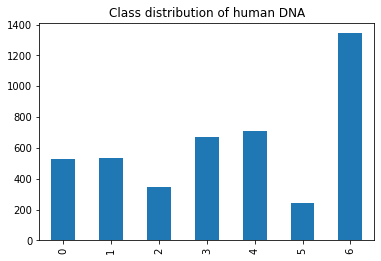

In [ ]:
human_df['class'].value_counts().sort_index().plot.bar()
plt.title("Class distribution of human DNA")

In [ ]:
def Kmers_funct(seq, size):
    s = [seq[x:x+size].lower() for x in range(0 , len(seq) - size + 1 ,6)]
    return ' '.join(s)

k-mers function returns all of a sequence's subsequences of length , such that the sequence AGAT would have four monomers (A, G, A, and T), three 2-mers (AG, GA, AT), two 3-mers (AGA and GAT) and one 4-mer (AGAT) .
i've converted the dna sequence to a sentece of k mers in order to treat it as a normal nlp task .

In [ ]:
human_df['k_mers'] = human_df['sequence'].apply((lambda x: Kmers_funct(x , 9)))

In [ ]:
human_df = human_df.drop('sequence' , axis = 1)

In [ ]:
human_df

,class,k_mers
0,4,atgccccaa caactaaat aatactacc accgtatgg tggccc...
1,4,atgaacgaa gaaaatctg ctgttcgct gcttcattc ttcatt...
2,3,atgtgtggc ggcatttgg tgggcgctg ctgtttggc ggcagt...
3,3,atgtgtggc ggcatttgg tgggcgctg ctgtttggc ggcagt...
4,3,atgcaacag cagcatttt tttgaattt tttgaatac taccag...
...,...,...
4375,0,atggaagat gatttggag gaggaaaca acattattt tttgaa...
4376,6,atgcagtcc tcctttcgg cgggagcaa caaagcagt agttac...
4377,6,atgcagtcc tcctttcgg cgggagcaa caaagcagt agttac...
4378,6,atggggcac cacctggtt gtttgctgt tgtctgtgt tgtggc...


# Tokenization ✅

In [ ]:
from keras.preprocessing.text import Tokenizer
max_features = 90000
tk = Tokenizer(lower = True , num_words = max_features)
full_text = list(human_df['k_mers'].values)
tk.fit_on_texts(full_text)

In [ ]:
human_df['t'] = tk.texts_to_sequences(human_df['k_mers'])

In [ ]:
m = np.max(human_df['t'].apply((lambda x: len(x))))
m

2472

In [ ]:
max_len = 2472
x = pad_sequences(human_df['t'], maxlen = max_len)
x.shape
#adding a pad to our tokenized sentence to make them all of the same length .

(4380, 2472)

In [ ]:
y = np.array(human_df['class'])
y.shape

(4380,)

In [ ]:
from imblearn.over_sampling import ADASYN
adasyn = ADASYN()
x, y = adasyn.fit_resample(x , y)

**SMOTE 🎈:** 



Synthetic Minority Over sampling Technique (SMOTE) algorithm applies KNN approach where it selects K nearest neighbors, joins them and creates the synthetic samples in the space. The algorithm takes the feature vectors and its nearest neighbors, computes the distance between these vectors. The difference is multiplied by random number between (0, 1) and it is added back to feature. SMOTE algorithm is a pioneer algorithm and many other algorithms are derived from SMOTE , one of these algorithms is ADASYN .

🍂🍂🍂🍂🍂🍂🍂🍂🍂🍂🍂

**ADASYN ❄:**

ADAptive SYNthetic (ADASYN) is based on the idea of adaptively generating minority data samples according to their distributions using K nearest neighbor. The algorithm adaptively updates the distribution and there are no assumptions made for the underlying distribution of the data.  The algorithm uses Euclidean distance for KNN Algorithm.

🍂🍂🍂🍂🍂🍂🍂🍂🍂🍂🍂

**The key difference between ADASYN and SMOTE 🌻 :**

 is that the former dont put the generated elements in linearity with the original ones , instead a random small number will be added to break the linear position , this render our generated instances more realistic.

In [ ]:
unique, counts = np.unique(y, return_counts=True)
print(np.asarray((unique, counts)).T)

[['0' 1276]
 ['1' 1371]
 ['2' 1346]
 ['3' 1239]
 ['4' 1334]
 ['5' 1348]
 ['6' 1343]]


now we can see that the data is balanced 

# CNN_LSTM :
i've used the cnn conv1D layers for feature extraction from text since it is hard for lstm to detect features , beside the impossible fact of select ing features manually as we were used to do in data mining problems , so cnn was the best choice then i've used lstm since it have a long term memory which maybe important in our case to help in dna classification .

In [ ]:
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
model = Sequential()
model.add(Embedding(90000 , 1000 , input_length = 2472))
model.add(Conv1D(filters = 128 , kernel_size = 5, padding = 'valid', activation = 'relu'))
model.add(MaxPooling1D(pool_size = 2))
model.add(SpatialDropout1D(0.4))
model.add(Conv1D(filters = 256 , kernel_size = 3, padding = 'valid', activation = 'relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(LSTM(40, dropout=0.4, recurrent_dropout=0.5 , return_sequences= True))
model.add(LSTM(10, dropout=0.2, recurrent_dropout=0.2 , return_sequences= False))
model.add(Dense(7,activation='softmax'))
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2472, 1000)        90000000  
                                                                 
 conv1d (Conv1D)             (None, 2468, 128)         640128    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1234, 128)        0         
 )                                                               
                                                                 
 spatial_dropout1d (SpatialD  (None, 1234, 128)        0         
 ropout1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 1232, 256)         98560     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 616, 256)         0

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x , y , test_size = 0.30, random_state = 42)

In [ ]:
x_train.shape , x_test.shape , y_train.shape , y_test.shape 

((6479, 2472), (2778, 2472), (6479,), (2778,))

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train , y_train , test_size = 0.20, random_state = 42)

In [ ]:
x_train.shape , x_val.shape , y_train.shape , y_val.shape 

((5183, 2472), (1296, 2472), (5183,), (1296,))

In [ ]:
y_train = [np.int32(numeric_string) for numeric_string in y_train]
y_train = np.array(y_train)

In [ ]:
y_test = [np.int32(numeric_string) for numeric_string in y_test]
y_test = np.array(y_test)

In [ ]:
y_val = [np.int32(numeric_string) for numeric_string in y_val]
y_val = np.array(y_val)

In [ ]:
x_train.shape , x_val.shape , y_train.shape , y_val.shape 

((5183, 2472), (1296, 2472), (5183,), (1296,))

In [ ]:
5183//40 , 1296//40

(129, 32)

In [ ]:
model.fit(x_train, y_train, epochs = 5 , batch_size = 40 , validation_data = (x_val , y_val), steps_per_epoch = 129 , validation_steps = 32)

Epoch 1/5
129/129 [==============================] - 772s 6s/step - loss: 1.8299 - accuracy: 0.2434 - val_loss: 1.6291 - val_accuracy: 0.3492
Epoch 2/5
129/129 [==============================] - 760s 6s/step - loss: 1.0967 - accuracy: 0.5623 - val_loss: 1.7362 - val_accuracy: 0.3984
Epoch 3/5
129/129 [==============================] - 742s 6s/step - loss: 0.7175 - accuracy: 0.7503 - val_loss: 1.7566 - val_accuracy: 0.4492
Epoch 4/5
129/129 [==============================] - 727s 6s/step - loss: 0.4048 - accuracy: 0.8909 - val_loss: 1.9991 - val_accuracy: 0.4664
Epoch 5/5
129/129 [==============================] - 702s 5s/step - loss: 0.2356 - accuracy: 0.9512 - val_loss: 2.1212 - val_accuracy: 0.4766


In [ ]:
model.evaluate(x_test , y_test)

In [ ]:
# from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
# from keras.models import Sequential
# from tensorflow.compat.v1.keras.layers import Concatenate
# cnn_model = Sequential()
# cnn_model.add(Embedding(9000, 100, input_length = 649))
# cnn_model.add(Conv1D(filters = 128, kernel_size = 2, padding = 'same', activation = 'relu'))
# cnn_model.add(MaxPooling1D(pool_size=2))

# cnn_model.add(Conv1D(filters = 64, kernel_size = 2, padding = 'same', activation = 'relu'))
# cnn_model.add(MaxPooling1D(pool_size = 2))

# cnn_model.add(Conv1D(filters = 32, kernel_size = 2, padding = 'same', activation = 'relu'))
# cnn_model.add(MaxPooling1D(pool_size = 2))
# cnn_model.add(Flatten())

# lstm_model = Sequential()
# lstm_model.add(Embedding(9000, 100, input_length = 649))
# lstm_model.add(Bidirectional(CuDNNLSTM(50, return_sequences = True)))
# lstm_model.add(Flatten()) #we can delete flatten if we set return sequences to false 

# merge = Concatenate([lstm_model, cnn_model])
# hidden = Dense(7, activation = 'sigmoid')
# conc_model = Sequential()
# conc_model.add(merge)
# conc_model.add(hidden)
# c_model = Model([(649,1),(649,1)],1)
# Input(shape=(27, 27, 1))
# conc_model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])


In [ ]:
# print(c_model.summary())

In [ ]:
# conc_model.fit(x_train, y_train, epochs = 20, batch_size = 100)

In [ ]:
# from keras.layers.merge import concatenate
# from keras.models import Model, Sequential
# from keras.layers import Dense, Input , MaxPooling1D

# model1_in = Input(shape=(649))
# model11_out = Embedding(9000, 300)(model1_in)
# model12_out = Conv1D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu')(model11_out)
# model13_out = MaxPooling1D(pool_size=2)(model12_out)
# model1_out = Flatten()(model13_out)
# model1 = Model(model1_in, model1_out)

# model2_in = Input(shape=(649))
# model21_out = Embedding(9000, 300)(model2_in)
# model22_out = Bidirectional(LSTM(20, return_sequences = True))(model21_out)
# model2_out = Flatten()(model22_out)
# model2 = Model(model2_in, model2_out)


# concatenated = concatenate([model1_out, model2_out])
# out = Dense(1, activation='softmax', name='output_layer')(concatenated)

# merged_model = Model([model1_in, model2_in], out)
# merged_model.compile(loss='binary_crossentropy', optimizer='adam', 
# metrics=['accuracy'])

# checkpoint = ModelCheckpoint('weights.h5', monitor='val_acc',
# save_best_only=True, verbose=2)
# early_stopping = EarlyStopping(monitor="val_loss", patience=2)


In [ ]:
# merged_model.summary()

In [ ]:
# merged_model.fit([x_train , x_train ], y = y_train, batch_size = 100, epochs = 10)

In [ ]:
# merged_model.evaluate([x_train , x_train ], y=y_train)

In [ ]:
# from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
# from keras.models import Sequential
# model = Sequential()
# model.add(Embedding(9000 , 100 , input_length = 649))
# model.add(Conv1D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(SpatialDropout1D(0.4))
# model.add(Conv1D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Conv1D(filters = 128, kernel_size = 5, padding = 'same', activation = 'relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(SpatialDropout1D(0.4))
# model.add(Bidirectional(LSTM(40, dropout=0.5, recurrent_dropout=0.2 , return_sequences= False)))
# model.add(Dense(10,activation='ReLU'))
# model.add(Dense(7,activation='softmax'))
# model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
# print(model.summary())

In [ ]:
# model.fit(x_train, y_train, epochs = 10, batch_size = 30)

In [ ]:
# model.evaluate(x_test ,y_test)